In [2]:
import matplotlib as mpl
import pandas as pd
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Data from the tables
# The format is a dictionary of dictionaries where the outer key is the dataset ID,
# and the inner key is the number of demos, and the value is a list of results for each method
data_llava = pd.DataFrame({
    1: {1: [.50, .85, .65], 2: [.53, .89, .61], 4: [.55, .88, .55]},
    2: {1: [.39, .48, .25], 2: [.46, .56, .32], 4: [.50, .66, .50]},
    3: {1: [.54, .61, .60], 2: [.58, .61, .61]},
    4: {1: [.33, .38, .20], 2: [.36, .49, .19], 4: [.38, .51, .38]},
    5: {1: [.46, .57, .51], 2: [.51, .62, .54], 4: [.54, .63, .54]},
    6: {1: [.29, .46, .28], 2: [.37, .65, .30], 4: [.43, .70, .43]},
    8: {1: [.44, .48, .53], 2: [.50, .60, .55], 4: [.54, .63, .56]},
    9: {1: [.33, .53, .30], 2: [.38, .60, .30], 4: [.43, .62, .38]},
    10: {1: [.39, .63, .45], 2: [.47, .72, .50], 4: [.52, .72, .55]},
    11: {1: [.41, .60, .38], 2: [.46, .69, .42], 4: [.51, .68, .49]}
})

data_clip = pd.DataFrame({
    1: {1: [25.10, 29.33, 25.92], 2: [25.47, 30.03, 25.64], 4: [25.70, 29.98, 25.70]},
    2: {1: [23.41, 24.54, 21.52], 2: [23.81, 25.72, 21.88], 4: [24.14, 26.81, 24.14]},
    3: {1: [26.34, 26.24, 25.87], 2: [27.00, 26.87, 25.62]},
    4: {1: [19.52, 21.51, 19.27], 2: [19.95, 24.25, 19.23], 4: [20.25, 24.86, 20.25]},
    5: {1: [24.98, 27.48, 25.66], 2: [25.76, 28.24, 26.10], 4: [26.40, 28.35, 26.40]},
    6: {1: [21.11, 25.48, 21.99], 2: [22.91, 28.30, 22.07], 4: [23.89, 29.06, 23.89]},
    8: {1: [22.83, 23.62, 23.53], 2: [23.63, 24.80, 23.65], 4: [24.00, 24.39, 23.91]},
    9: {1: [20.98, 24.06, 21.27], 2: [21.83, 24.95, 21.24], 4: [22.31, 24.82, 21.88]},
    10: {1: [20.73, 24.88, 21.44], 2: [22.36, 26.12, 22.34], 4: [23.36, 25.91, 23.30]},
    11: {1: [21.28, 24.42, None], 2: [22.83, 25.46, None], 4: [None, 24.59, None]}
})

In [6]:
def flatten(data):
    data = data.values.flatten()
    results = []
    for row in data:
        if not isinstance(row, list):
            results.extend([np.nan, np.nan, np.nan])
            continue
        for col in row: 
            if col is None:
                results.append(np.nan)
            else:
                results.append(col)
    return np.array(results)

def get_index(data, idx, task_indices = None):
    """_summary_

    Args:
        data (_type_): llava or clip
        idx (_type_): indicate the number of demonstrations
        task_indices (_type_, optional): indicate which dataset to use, from 1 to 11
    """
    results = []
    if task_indices is None:
        task_indices = data.column_names

    for col in task_indices:
        if idx in data[col].index:
            if not isinstance(data[col][idx], list):
                continue
            for item in data[col][idx]:
                if item is None:
                    results.append(np.nan)
                else:
                    results.append(item)
        else:
            results.extend([np.nan, np.nan, np.nan])
    
    return np.array(results, dtype=float)

def get_model(data, model, task_indices = None):
    model_dict = {
        'emu': 0,
        'seed-llama': 1,
        'gill': 2,
    }
    results = []
    if task_indices is None:
        task_indices = data.column_names

    for col in task_indices:
        for row in data[col]:
            if not isinstance(row, list):
                continue
            if row[model_dict[model]] is None:
                results.append(np.nan)
            else:
                results.append(row[model_dict[model]])
    return np.array(results, dtype=float)

def get_model_index(data, model, shot_idx, task_indices = None):
    model_dict = {
        'emu': 0,
        'seed-llama': 1,
        'gill': 2,
    }
    results = []
    if task_indices is None:
        task_indices = data.column_names

    for col in task_indices:
        if shot_idx in data[col].index:
            if not isinstance(data[col][shot_idx], list):
                continue
            if data[col][shot_idx][model_dict[model]] is None:
                results.append(np.nan)
            else:
                results.append(data[col][shot_idx][model_dict[model]])
        else:
            results.extend([np.nan, np.nan, np.nan])
    
    return np.array(results, dtype=float)


In [5]:
vec_llava = flatten(data_llava)
vec_clip = flatten(data_clip)

nan_llava = np.where(np.isnan(vec_llava))[0]
nan_clip = np.where(np.isnan(vec_clip))[0]
nan_idx = np.union1d(nan_llava, nan_clip)

vec_llava = np.delete(vec_llava, nan_idx)
vec_clip = np.delete(vec_clip, nan_idx)

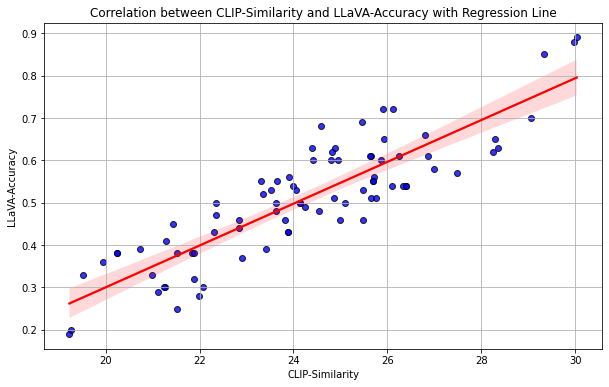

In [5]:
# Plot with a regression line and confidence interval
plt.figure(figsize=(10, 6))
sns.regplot(x=vec_clip, y=vec_llava, ci=95, color="blue", line_kws={'color': 'red'}, scatter_kws={'color': 'blue', 'edgecolor': 'k'})

plt.title('Correlation between CLIP-Similarity and LLaVA-Accuracy with Regression Line')
plt.xlabel('CLIP-Similarity')
plt.ylabel('LLaVA-Accuracy')
plt.grid(True)
plt.show()

In [6]:
# Computing the Pearson correlation coefficient
pearson_corr, p_value = scipy.stats.pearsonr(vec_llava, vec_clip)
print("Pearson correlation coefficient: ", pearson_corr)

Pearson correlation coefficient:  0.8721334752721673


/tmp/ipykernel_2103667/3041538051.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(oneshot, color='blue', shade=True, label='1-shot')
/tmp/ipykernel_2103667/3041538051.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='2-shot')
/tmp/ipykernel_2103667/3041538051.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='4-shot')


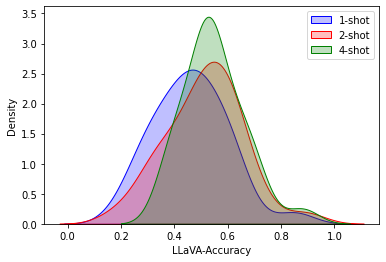

In [7]:
# scatter plot
oneshot = get_index(data_llava, 1)
twoshot = get_index(data_llava, 2)
fourshot = get_index(data_llava, 4)

# density plot
ax = sns.kdeplot(oneshot, color='blue', shade=True, label='1-shot')
sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='2-shot')
sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='4-shot')
ax.set_xlabel('LLaVA-Accuracy')

# add legend
plt.legend()

/tmp/ipykernel_2103667/1918366050.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(oneshot, color='blue', shade=True, label='1-shot')
/tmp/ipykernel_2103667/1918366050.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='2-shot')
/tmp/ipykernel_2103667/1918366050.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='4-shot')


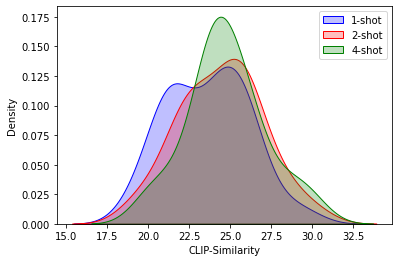

In [8]:
# scatter plot
oneshot = get_index(data_clip, 1)
twoshot = get_index(data_clip, 2)
fourshot = get_index(data_clip, 4)

# density plot
ax = sns.kdeplot(oneshot, color='blue', shade=True, label='1-shot')
sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='2-shot')
sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='4-shot')
ax.set_xlabel('CLIP-Similarity')

# add legend
plt.legend()

/tmp/ipykernel_2103667/41967960.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(emu, color='blue', shade=True, label='EMU')
/tmp/ipykernel_2103667/41967960.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(seed, color='red', shade=True, ax=ax, label='SEED-LLAMA')
/tmp/ipykernel_2103667/41967960.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gill, color='green', shade=True, ax=ax, label='GILL')


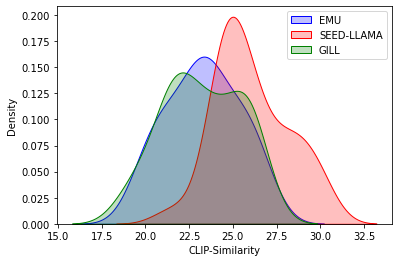

In [9]:
emu = get_model(data_clip, 'emu')
seed = get_model(data_clip, 'seed-llama')
gill = get_model(data_clip, 'gill')

# density plot
ax = sns.kdeplot(emu, color='blue', shade=True, label='EMU')
sns.kdeplot(seed, color='red', shade=True, ax=ax, label='SEED-LLAMA')
sns.kdeplot(gill, color='green', shade=True, ax=ax, label='GILL')
ax.set_xlabel('CLIP-Similarity')

# add legend
plt.legend()

/tmp/ipykernel_2103667/4260888147.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(emu, color='blue', shade=True, label='EMU')
/tmp/ipykernel_2103667/4260888147.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(seed, color='red', shade=True, ax=ax, label='SEED-LLAMA')
/tmp/ipykernel_2103667/4260888147.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(gill, color='green', shade=True, ax=ax, label='GILL')


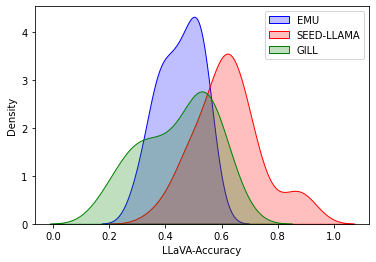

In [10]:
emu = get_model(data_llava, 'emu')
seed = get_model(data_llava, 'seed-llama')
gill = get_model(data_llava, 'gill')

# density plot
ax = sns.kdeplot(emu, color='blue', shade=True, label='EMU')
sns.kdeplot(seed, color='red', shade=True, ax=ax, label='SEED-LLAMA')
sns.kdeplot(gill, color='green', shade=True, ax=ax, label='GILL')
ax.set_xlabel('LLaVA-Accuracy')

# add legend
plt.legend()

/tmp/ipykernel_2103667/1110722674.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(oneshot, color='blue', shade=True, label='1-shot')
/tmp/ipykernel_2103667/1110722674.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='2-shot')
/tmp/ipykernel_2103667/1110722674.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='4-shot')


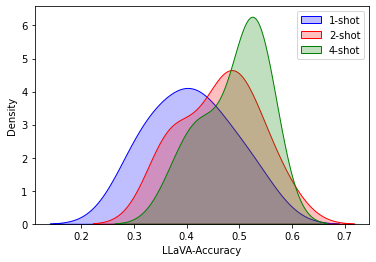

In [11]:
# scatter plot
model = 'emu'
oneshot = get_model_index(data_llava, model, 1)
twoshot = get_model_index(data_llava, model, 2)
fourshot = get_model_index(data_llava, model, 4)

# density plot
ax = sns.kdeplot(oneshot, color='blue', shade=True, label='1-shot')
sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='2-shot')
sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='4-shot')
ax.set_xlabel('LLaVA-Accuracy')

# add legend
plt.legend()

/tmp/ipykernel_2103667/3089785984.py:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(oneshot, color='blue', shade=True, label='Emu')
/tmp/ipykernel_2103667/3089785984.py:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='SEED-LLaMA')
/tmp/ipykernel_2103667/3089785984.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='GILL')


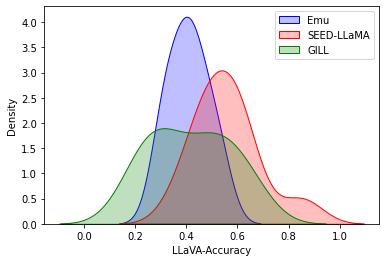

In [12]:
# scatter plot
shot = 1
oneshot = get_model_index(data_llava, 'emu', shot)
twoshot = get_model_index(data_llava, 'seed-llama', shot)
fourshot = get_model_index(data_llava, 'gill', shot)

# density plot
ax = sns.kdeplot(oneshot, color='blue', shade=True, label='Emu')
sns.kdeplot(twoshot, color='red', shade=True, ax=ax, label='SEED-LLaMA')
sns.kdeplot(fourshot, color='green', shade=True, ax=ax, label='GILL')
ax.set_xlabel('LLaVA-Accuracy')

# add legend
plt.legend()

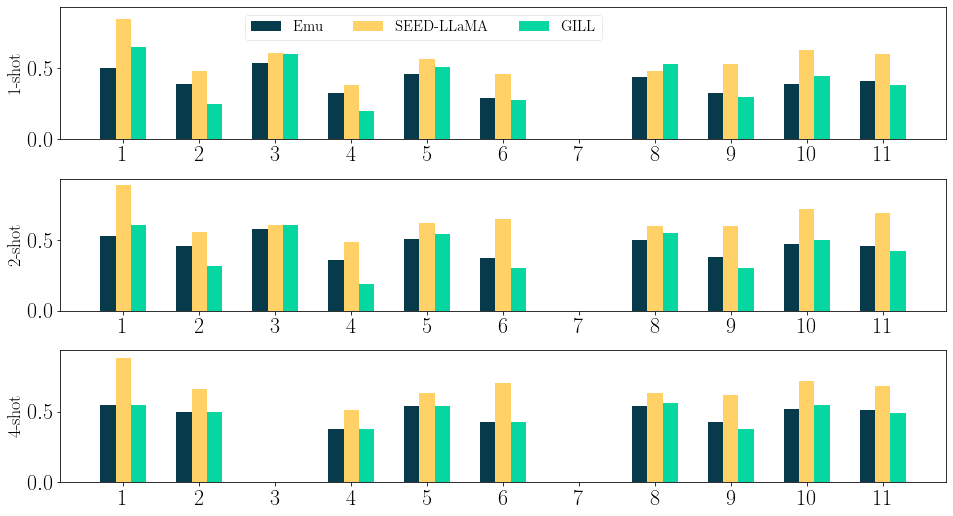

In [37]:
plt.rc('font', family='serif', serif='times new roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 2.5
markers = ['s', 'o']
colors = ['#073B4C','#FFD166','#06D6A0','#118AB2', '#DD3497', '#AE017E', '#7A0177', '#49006A' ]
models = ['Emu', 'SEED-LLaMA', 'GILL']
lts = ['--', '-']
marker_sizes = [6, 5]
shots = [1,2,4]

fig, ax = plt.subplots(nrows = 3, ncols = 1, sharey = True)
fig.subplots_adjust(left=0.16, bottom=.24, right=0.98, top=0.9, wspace=0.05, hspace = 0.3) #margin of the figure
fig.set_size_inches(15, 10) #exact size of the figure


# Plotting bar plots for each cluster
clusters = range(1, 12)  # Clusters from 1 to 11
bar_width = 0.2  # Width of each bar

for row, num_shot in enumerate(shots):
    for i, cluster in enumerate(clusters):
        try:
            index_data = get_index(data_llava, num_shot, [cluster])
        except KeyError:
            continue
        
        for j in range(index_data.shape[0]):
            ax[row].bar(i + j*bar_width, index_data[j], width=bar_width, color=colors[j % len(colors)], label = models[j])
            if i == 0 and row == 0:
                ax[row].legend(bbox_to_anchor=(0.2, 1), ncol=3, fontsize=15)

    ax[row].set_xticks([i + bar_width for i in range(len(clusters))])
    ax[row].set_xticklabels(range(1, 12))
    ax[row].set_ylabel(f'{num_shot}-shot', fontsize=18)


# Show the plot
plt.show()